In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
import pandas.plotting as pd_plot

import missingno as msno
import pandas_profiling

import re

import statsmodels.imputation.mice

from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing  import StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import scale
from sklearn.linear_model import LassoCV
import random

# Feature Selection/Dimension Reduction

In [2]:
OriginalDatasetwTypes = pd.read_csv("CleanedDataset.csv")
OriginalDataset = OriginalDatasetwTypes.copy().drop(["Unnamed: 0", "Sleeves", "P&P", "Frac Ports", \
                                      "Repeater Ports", "CT"], axis = 1)
DatasetDropna = pd.read_csv("NoNanDataset.csv")
DatasetMean = pd.read_csv("MeanImputationDS.csv")
DatasetII = pd.read_csv("IterativeImputeDS.csv")
imputer = KNNImputer(n_neighbors=10)
DatasetKNN = imputer.fit_transform(OriginalDataset.copy().select_dtypes([np.number]))
DatasetKNN = pd.DataFrame(DatasetKNN, columns = OriginalDataset.copy().select_dtypes([np.number]).columns)
from impyute.imputation import cs
np.random.seed(9)
data = OriginalDataset.copy().select_dtypes([np.number]).to_numpy()
DatasetMICE = cs.mice(data)
DatasetMICE = pd.DataFrame(DatasetMICE, columns = OriginalDataset.copy().select_dtypes([np.number]).columns)
DatasetIIandCI = pd.read_csv("DatasetIIandCI.csv")

## LASSO Regression

### Dataset with Dropped Data

Train score: 0.9784066889015249
Test score: 0.9754368554324415
Number of coefficients used: 8
Root mean squared error: 7.8128621831727125
[-2.79849395e-04  1.41248859e-01  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  6.09445285e-07  9.85529350e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.08852376e-01  2.37266433e-01
  6.60869773e-02  0.00000000e+00 -1.59927173e-03]


Lateral Length    -2.798494e-04
Stages             1.412489e-01
Township           0.000000e+00
Range              0.000000e+00
Section           -0.000000e+00
Total Prop, lbs    6.094453e-07
Fluid, bbls        9.855293e-06
Best1 Mo BOPD      0.000000e+00
Best3 Mo BOPD      0.000000e+00
Best6 Mo BOPD      0.000000e+00
Best9 Mo BOPD      1.088524e-01
Best12 Mo BOPD     2.372664e-01
Latitude           6.608698e-02
Longitude          0.000000e+00
SPACING_CAPPED    -1.599272e-03
dtype: float64

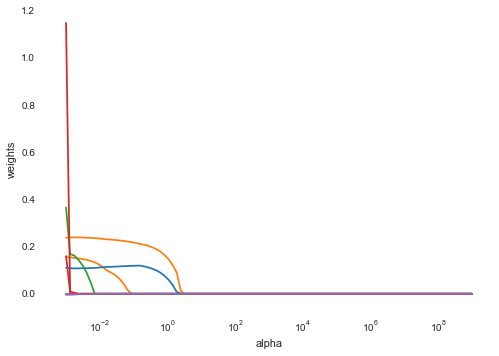

In [3]:
from math import sqrt
X = DatasetDropna.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetDropna["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Best12 Mo BOPD", "Stages", "Best9 Mo BOPD", "Latitude", "SPACING_CAPPED", "Lateral Length", "Best9 Mo BOPD", "Section", "SPACING_CAPPED", "Fluid, bbls", "Total Prop, lbs"</pre>
<b>Features with absolute weights that are greater than > 0.01:</b> 
    <pre>"Best12 Mo BOPD", "Stages", "Best9 Mo BOPD", "Latitude"</pre>

<b><i>Notes:</i></b> This Dataset is a highly truncated version of the full dataset with missing values. After optimization these features were the ones deemed to be important to predict 12 month Cumulative production.

<b>Best12 Mo BOPD:</b> The feature with the highest absolute weight was Best the best "Barrels of Oil per day" value in the 12<sup>th</sup> month. This along with the best oil production per day in the 9<sup>th</sup> month are useful in determining 12 month cumulative production as in general the best oil production rate at the later months are generally useful in determining the cumulative oil production in a year. On another note, since the oil production rates are directly proportional to each other, the best oil production rates of the earlier months can be extrapolated from the later months (months 12 and 9).

<b>Stages:</b> It is reasonable to assume that there is importance for the number of stages within a well and predicting 12 month cumulative production. The number of stages can also be used to ascertain the length of the well, the total amount of fluid used, along with the amount of proppant (explaining the low to zero feature importance in their weightings).

<b>Best9 Mo BOPD:</b> See Best12 Mo BOPD

<b>Latitude:</b> Due to the truncated dataset, This is one of the only datasets where the Latitude was a more significant factor than the longitude in predicting 12 month cumulative oil production.

<b>Other:</b> The space or density per well, feature importance can be useful in predicting 12 month cumulative production, mostly as in well-dense areas (low spacing cap) some oil in a reservoir will flow to multiple wells. However, since this only refers to the density with respect to other wells, it will only serve as a good predictor for 12 month cumulative production in certain clusters of wells.

### Mean Imputation Dataset

Train score: 0.7681769797823996
Test score: 0.7731691265220009
Number of coefficients used: 11
Root mean squared error: 25.388912684462824
[-0.00000000e+00  1.96054499e-01 -3.82520820e-01 -0.00000000e+00
 -2.08582123e-02  3.39488331e-06  1.20311613e-04  0.00000000e+00
  5.46325489e-02  8.85455211e-02  3.35620948e-02  9.45143852e-02
 -0.00000000e+00  9.11109931e+00 -1.01208786e-02]


Lateral Length    -0.000000
Stages             0.196054
Township          -0.382521
Range             -0.000000
Section           -0.020858
Total Prop, lbs    0.000003
Fluid, bbls        0.000120
Best1 Mo BOPD      0.000000
Best3 Mo BOPD      0.054633
Best6 Mo BOPD      0.088546
Best9 Mo BOPD      0.033562
Best12 Mo BOPD     0.094514
Latitude          -0.000000
Longitude          9.111099
SPACING_CAPPED    -0.010121
dtype: float64

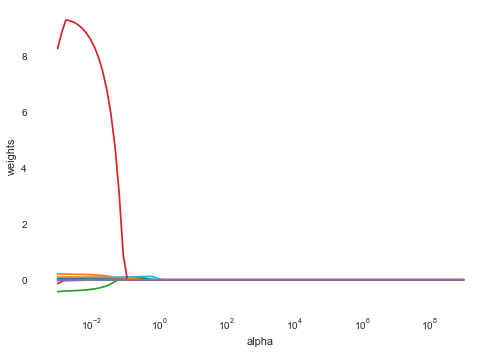

In [4]:
X = DatasetMean.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetMean["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Longitude", "Township", "Stages", "Best12 Mo BOPD", "Best6 Mo BOPD", "Best3 Mo BOPD", "Best9 Mo BOPD", "Section", "SPACING_CAPPED", "Fluid, bbls", "Total Prop, lbs"</pre>
<b>Features with absolute weights that are greater than > 0.01:</b> 
    <pre>"Longitude", "Township", "Stages", "Best12 Mo BOPD", "Best6 Mo BOPD", "Best3 Mo BOPD", "Best9 Mo BOPD", "Section", "SPACING_CAPPED"</pre>
<b><i>Notes:</i></b> This dataset revolves around a single variate imputation, many multivariate relations are lost, especially amongst those with significant percent of imputed data, such as with "Best12 Mo BOPD", "Best9 Mo BOPD", and "Best6 Mo BOPD" to name a few. Moreover, compared to the truncated dataset this dataset is about 4 times as large.

<b>Longitude:</b> The two positional features to indicate a location on a grid used are Longitude (East and West) and Township (North and South), this is opposed to Range and latitude. Regardless, East and West positioning seems to be a more important predictor of 12 month Cumulative Production.

<b>Township:</b> See Longitude

<b>Stages:</b> Since the number of stages did not have many imputed values, its importance in terms of rank did not change significantly, rather the other features importance in terms of rank changed around this. For more information see droppeddataset LASSO analysis.

<b>Best12 Mo BOPD:</b> Since the Best12 Mo BOPD and Best9 Mo BOPD has some of the highest amount of quantitative imputed values (the mean in this case), siginficantly decreasing its variance and predictive capabilities for 12 month Cumulative production. To counteract the loss in predictive capabilities the feature importances of the best month productions (features with lower imputed value counts) of the earlier months have been increased.

<b>Best6 Mo BOPD:</b> See Best12 Mo BOPD

<b>Best3 Mo BOPD:</b> See Best12 Mo BOPD

<b>Best9 Mo BOPD:</b> See Best12 Mo BOPD

<b>SPACING_CAPPED:</b> Same reasoning as with the dataset with the dropped entries

<b>Other:</b> The number of stages could be a better predictor in 12 month cumulative production than lateral length, fluid, bbls, and total proppant.

### Iterative Imputatoin Dataset

Train score: 0.9192925646975338
Test score: 0.9177666415052342
Number of coefficients used: 11
Root mean squared error: 15.286815825262845
[-4.92778282e-04  2.59100290e-01 -1.84685448e-01 -0.00000000e+00
 -9.18864396e-04  2.15643233e-06  7.39272436e-05 -1.97150479e-03
 -0.00000000e+00 -1.49324390e-01  0.00000000e+00  5.63580139e-01
 -0.00000000e+00  1.68669839e+00 -1.57063397e-02]


Lateral Length    -0.000493
Stages             0.259100
Township          -0.184685
Range             -0.000000
Section           -0.000919
Total Prop, lbs    0.000002
Fluid, bbls        0.000074
Best1 Mo BOPD     -0.001972
Best3 Mo BOPD     -0.000000
Best6 Mo BOPD     -0.149324
Best9 Mo BOPD      0.000000
Best12 Mo BOPD     0.563580
Latitude          -0.000000
Longitude          1.686698
SPACING_CAPPED    -0.015706
dtype: float64

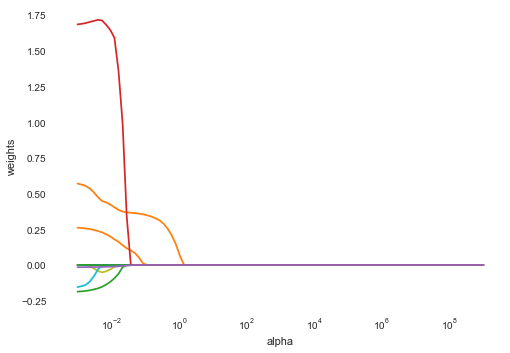

In [5]:
X = DatasetII.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetII["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Longitude", "Best12 Mo BOPD", "Stages", "Township", "SPACING_CAPPED", "Best1 Mo BOPD", "Section", "Lateral Length", "Fluid, bbls", "Total Prop, lbs"</pre>
<b>Features with absolute weights that are greater than > 0.01:</b> 
    <pre>"Longitude", "Best12 Mo BOPD", "Stages", "Township", "SPACING_CAPPED"</pre>

<b>Longitude:</b>  The two positional features to indicate a location on a grid used are Longitude (East and West) and Township (North and South), this is opposed to Range and latitude. Regardless, East and West positioning seems to be a more important predictor of 12 month Cumulative Production.

<b>Best12 Mo BOPD:</b> The process of Iterative Imputation from sklearn ensures that despite Best12 Mo BOPD having the highest amount of imputed quantitative values, Best12 Mo BOPD still maintains its feature importance. This is due to the maintainance of multivariate relationships between features. Despite this, some of the other more complete Best oil production months is used to buff of the predictive values

<b>Stages:</b> Since the number of stages did not have many imputed values, its importance in terms of rank did not change significantly, rather the other features importance in terms of rank changed around this. For more information see LASSO Regression analysis of the dataset with dropped entries.

<b>Township:</b> See Longitude

<b>SPACING_CAPPED:</b> Same reasoning as with the dataset with the dropped entries

<b>Other:</b> The number of stages could be a better predictor in 12 month cumulative production than lateral length, fluid, bbls, and total proppant.

### K- NN Imputation Dataset

Train score: 0.7652285908428245
Test score: 0.7660899276286498
Number of coefficients used: 13
Root mean squared error: 25.78205206413322
[ 3.22046235e-04  3.66362212e-01 -2.73303591e-01 -0.00000000e+00
 -4.22946093e-02 -3.41260664e-06  1.18271029e-04  1.54890947e-03
  3.92475004e-02  1.20310563e-01  6.23826759e-02  5.21283508e-02
 -0.00000000e+00  6.99645423e+00  2.06923058e-03]


Lateral Length     0.000322
Stages             0.366362
Township          -0.273304
Range             -0.000000
Section           -0.042295
Total Prop, lbs   -0.000003
Fluid, bbls        0.000118
Best1 Mo BOPD      0.001549
Best3 Mo BOPD      0.039248
Best6 Mo BOPD      0.120311
Best9 Mo BOPD      0.062383
Best12 Mo BOPD     0.052128
Latitude          -0.000000
Longitude          6.996454
SPACING_CAPPED     0.002069
dtype: float64

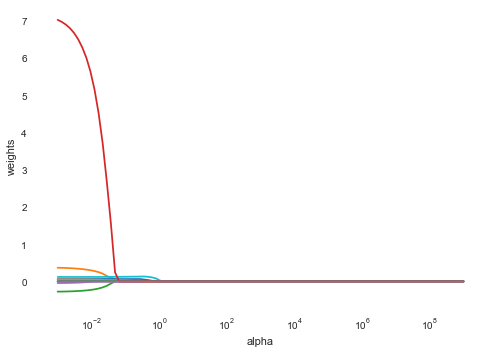

In [7]:
X = DatasetKNN.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetKNN["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Longitude", "Stages", "Township", "Best6 Mo BOPD", "Best9 Mo BOPD", "Best12 Mo BOPD", "Section", "Best3 Mo BOPD" "SPACING_CAPPED", "Best1 Mo BOPD", "Lateral Length", "Fluid, bbls", "Total Prop, lbs"</pre>
<b>Features with absolute weights that are greater than > 0.01:</b> 
    <pre>"Longitude", "Stages", "Township", "Best6 Mo BOPD", "Best9 Mo BOPD", "Best12 Mo BOPD", "Section", "Best3 Mo BOPD"</pre>

<b>Longitude:</b>  The two positional features to indicate a location on a grid used are Longitude (East and West) and Township (North and South), this is opposed to Range and latitude. Regardless, East and West positioning seems to be a more important predictor of 12 month Cumulative Production.


<b>Stages:</b> Since the number of stages did not have many imputed values, its importance in terms of rank did not change significantly, rather the other features importance in terms of rank changed around this. For more information see LASSO Regression analysis of the dataset with dropped entries.

<b>Township:</b> See Longitude

<b>Best6 Mo BOPD:</b> K-NN Imputation is a single variate imputation method and with k values greater than 1, many multivariate relations are lost if favor of maintaining inferential statistics of a single feature. Due to this, features with a significant amount of imputed values such as Best12 Mo BOPD and Best9 Mo BOPD have a decrease in feature importance while those related features with less imputed values get an increase, such as Best6 Mo BOPD.

<b>Best9 Mo BOPD:</b> See Best6 Mo BOPD

<b>Best12 Mo BOPD:</b> See Best6 Mo BOPD

<b>Best3 Mo BOPD:</b> See Best6 Mo BOPD

<b>Other:</b> The number of stages could be a better predictor in 12 month cumulative production than lateral length, fluid, bbls, and total proppant.

### MICE Imputation Dataset

Train score: 0.919159648628821
Test score: 0.9188427159690814
Number of coefficients used: 11
Root mean squared error: 15.1864677351114
[-4.64578771e-04  2.30263448e-01 -1.52098368e-01 -0.00000000e+00
 -0.00000000e+00  2.44671188e-06  7.13116893e-05  3.26710655e-02
 -4.42567803e-02 -1.82076693e-01  0.00000000e+00  6.08431341e-01
 -0.00000000e+00  1.73975868e+00 -1.52858872e-02]


Lateral Length    -0.000465
Stages             0.230263
Township          -0.152098
Range             -0.000000
Section           -0.000000
Total Prop, lbs    0.000002
Fluid, bbls        0.000071
Best1 Mo BOPD      0.032671
Best3 Mo BOPD     -0.044257
Best6 Mo BOPD     -0.182077
Best9 Mo BOPD      0.000000
Best12 Mo BOPD     0.608431
Latitude          -0.000000
Longitude          1.739759
SPACING_CAPPED    -0.015286
dtype: float64

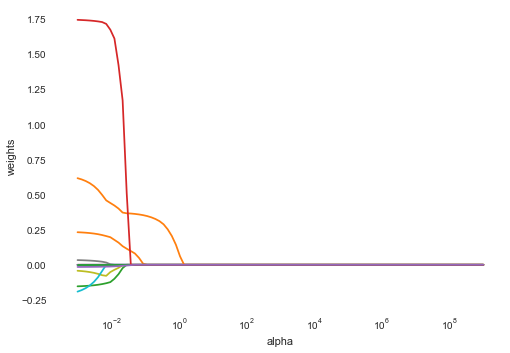

In [9]:
X = DatasetMICE.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetMICE["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Longitude", "Best12 Mo BOPD", "Stages", "Best6 Mo BOPD", "Township", "Best3 Mo BOPD", "Best1 Mo BOPD", "SPACING_CAPPED", "Lateral Length", "Fluid, bbls", "Total Prop, lbs"</pre>
<b>Features with absolute weights that are greater than > 0.01:</b> 
    <pre>"Longitude", "Best12 Mo BOPD", "Stages", "Best6 Mo BOPD", "Township", "Best3 Mo BOPD", "Best1 Mo BOPD", "SPACING_CAPPED"</pre>

<b>Longitude:</b>  The two positional features to indicate a location on a grid used are Longitude (East and West) and Township (North and South), this is opposed to Range and latitude. Regardless, East and West positioning seems to be a more important predictor of 12 month Cumulative Production.


<b>Best12 Mo BOPD:</b> MICE Imputation similiar to sklearn's iterative imputation ensures that despite Best12 Mo BOPD having the highest amount of imputed quantitative values, Best12 Mo BOPD still maintains its feature importance. This is due to the maintainance of multivariate relationships between features. Despite this, there is still a loss, and thus causes an increase in feature importance of other best month oil productions.

<b>Stages:</b> Since the number of stages did not have many imputed values, its importance in terms of rank did not change significantly, rather the other features importance in terms of rank changed around this. For more information see LASSO Regression analysis of the dataset with dropped entries.

<b>Best6 Mo BOPD:</b> See Best12 Mo BOPD

<b>Township:</b> See Longitude

<b>Best3 Mo BOPD:</b> See Best12 Mo BOPD

<b>Best1 Mo BOPD:</b> See Best12 Mo BOPD

<b>SPACING_CAPPED:</b> Same reasoning as with the dataset with the dropped entries

<b>Other:</b> The number of stages could be a better predictor in 12 month cumulative production than lateral length, fluid, bbls, and total proppant.

### Separating by Completion Type

In [10]:

Category = "Completion Type"
DatasetII[Category] = OriginalDatasetwTypes[Category]
DatasetII["Sleeves"] = OriginalDatasetwTypes["Sleeves"]
DatasetII["P&P"] = OriginalDatasetwTypes["P&P"]
DatasetII["Frac Ports"] = OriginalDatasetwTypes["Frac Ports"]
DatasetII["Repeater Ports"] = OriginalDatasetwTypes["Repeater Ports"]
DatasetII["CT"] = OriginalDatasetwTypes["CT"]
DatasetII = DatasetII.dropna(axis=0, subset=['Completion Type'])

DatasetIISleeves = pd.concat([\
                               DatasetII[DatasetII[Category] == \
                                          "Sleeves"], \
                               DatasetII[DatasetII[Category] == \
                                           "Sleeves and P & P"]])
DatasetIISleeves = DatasetIISleeves.fillna(0)

DatasetIIPandP = pd.concat([\
                            DatasetII[DatasetII[Category] == \
                                      "P & P"], \
                            DatasetII[DatasetII[Category] == \
                                      "Sleeves and P & P"], \
                            DatasetII[DatasetII[Category] == \
                                      "Frac Ports and P & P"], \
                            DatasetII[DatasetII[Category] == \
                                       "P & P and CT"], \
                            DatasetII[DatasetII[Category] == \
                                      "Repeater Ports and P & P"]])
DatasetIIPandP = DatasetIIPandP.fillna(0)

DatasetIIFracPorts = pd.concat([\
                                DatasetII[DatasetII[Category] == \
                                         "Frac Ports"], \
                                DatasetII[DatasetII[Category] == \
                                         "Frac Ports and P & P"], \
                                DatasetII[DatasetII[Category] == \
                                         "Frac Ports and Repeater Ports"]])
DatasetIIFracPorts = DatasetIIFracPorts.fillna(0)

DatasetIIRepeaterPorts = pd.concat([\
                                    DatasetII[DatasetII[Category] == \
                                        "Frac Ports and Repeater Ports"],
                                    DatasetII[DatasetII[Category] == \
                                              "Repeater Ports and P & P"]])
DatasetIIRepeaterPorts = DatasetIIRepeaterPorts.fillna(0)

DatasetIICT = pd.concat([\
                         DatasetII[DatasetII[Category] == \
                                   "CT"], \
                         DatasetII[DatasetII[Category] == \
                                   "P & P and CT"]])
DatasetIICT = DatasetIICT.fillna(0)
DatasetIIOH = DatasetII[DatasetII[Category] == "OH"]
DatasetIIOH = DatasetIIOH.fillna(0)

DatasetIIScreen = DatasetII[DatasetII[Category] == "Screen"]
DatasetIIScreen = DatasetIIScreen.fillna(0)

DatasetIICementedL = DatasetII[DatasetII[Category] == "Cemented Liner"]
DatasetIICementedL = DatasetIICementedL.fillna(0)

DatasetIIPerforatedL = DatasetII[DatasetII[Category] == \
                                   "Perforated Liner"]
DatasetIIPerforatedL = DatasetIIPerforatedL.fillna(0)

DatasetIIother = pd.concat([DatasetIIOH, DatasetIIScreen, \
                           DatasetIICementedL, DatasetIIPerforatedL, DatasetIIFracPorts, DatasetIIRepeaterPorts])


### Sleeves

Train score: 0.9227018783782674
Test score: 0.9318787834980496
Number of coefficients used: 14
Root mean squared error: 12.159003281165456
[-6.01579778e-04  2.92234357e-01 -2.33246343e-01 -0.00000000e+00
 -2.27509030e-02  3.52410448e-06 -8.67943583e-06  4.52463622e-04
  1.76508375e-02 -9.65952755e-02 -0.00000000e+00  4.69638386e-01
 -0.00000000e+00  1.12472392e+00 -8.98397439e-03  1.29798992e-02
 -1.12132911e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]


Lateral Length    -0.000602
Stages             0.292234
Township          -0.233246
Range             -0.000000
Section           -0.022751
Total Prop, lbs    0.000004
Fluid, bbls       -0.000009
Best1 Mo BOPD      0.000452
Best3 Mo BOPD      0.017651
Best6 Mo BOPD     -0.096595
Best9 Mo BOPD     -0.000000
Best12 Mo BOPD     0.469638
Latitude          -0.000000
Longitude          1.124724
SPACING_CAPPED    -0.008984
Sleeves            0.012980
P&P               -0.112133
Frac Ports         0.000000
Repeater Ports     0.000000
CT                 0.000000
dtype: float64

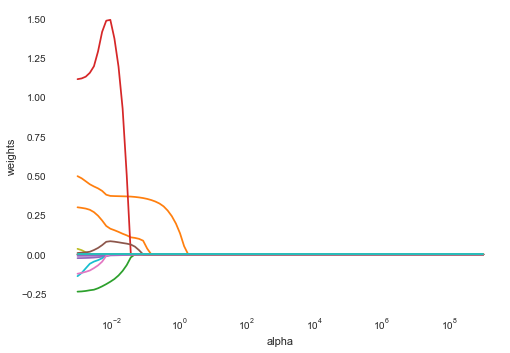

In [11]:
X = DatasetIISleeves.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetIISleeves["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Longitude", "Best12 Mo BOPD", "Stages", "Township", "PandP", "Best6 Mo BOPD", "Section", "Best3 Mo BOPD", "Sleeves", "SPACING_CAPPED", "Lateral Length", "Best1 Mo BOPD", "Fluid, bbls", "Total Prop, lbs"</pre>
<b>Features with weights that are greater than > 0.01:</b> 
    <pre>"Longitude", "Best12 Mo BOPD", "Stages", "Township", "PandP", "Best6 Mo BOPD", "Section", "Best3 Mo BOPD", "Sleeves"</pre>

<b>Longitude:</b>  The two positional features to indicate a location on a grid used are Longitude (East and West) and Township (North and South), this is opposed to Range and latitude. Regardless, East and West positioning seems to be a more important predictor of 12 month Cumulative Production.


<b>Best12 Mo BOPD:</b> Similar to the Iterative Imputation Dataset

<b>Stages:</b> Similar to Iterative Imputation Dataset

<b>Township:</b> See Longitude

<b>PandP:</b> For entries that have completion type sleeves, there is an importance to the number of pandp stages in predicting 12 month cumulative production. For more information, see the edgeworthbox notebook in models

<b>Best6 Mo BOPD:</b> Similar to Iterative Imputation Dataset

<b>Best3 Mo BOPD:</b> Similar to Iterative Imputation Dataset

<b>Sleeves:</b> It is interesting that the number of p and p stages within a well is more important in predicting 12 month cumulative production in wells with sleeves completion type than the number of sleeves. For more information, see the edgeworthbox notebook in models.

<b>Other:</b> The number of stages could be a better predictor in 12 month cumulative production than lateral length, fluid, bbls, and total proppant.

### P & P

Train score: 0.9125551725854727
Test score: 0.9105132713262579
Number of coefficients used: 14
Root mean squared error: 17.891623785825605
[-3.96501919e-04  1.66133851e-01 -2.90090980e-01 -0.00000000e+00
  4.43652486e-02  2.29731085e-06  8.04214463e-05 -3.34969436e-03
 -1.45171907e-02 -1.90360074e-01  0.00000000e+00  6.43827758e-01
 -0.00000000e+00  1.78774866e+00 -2.20032296e-02  1.38641192e-02
  0.00000000e+00  0.00000000e+00 -4.95397544e-01  0.00000000e+00]


Lateral Length    -0.000397
Stages             0.166134
Township          -0.290091
Range             -0.000000
Section            0.044365
Total Prop, lbs    0.000002
Fluid, bbls        0.000080
Best1 Mo BOPD     -0.003350
Best3 Mo BOPD     -0.014517
Best6 Mo BOPD     -0.190360
Best9 Mo BOPD      0.000000
Best12 Mo BOPD     0.643828
Latitude          -0.000000
Longitude          1.787749
SPACING_CAPPED    -0.022003
Sleeves            0.013864
P&P                0.000000
Frac Ports         0.000000
Repeater Ports    -0.495398
CT                 0.000000
dtype: float64

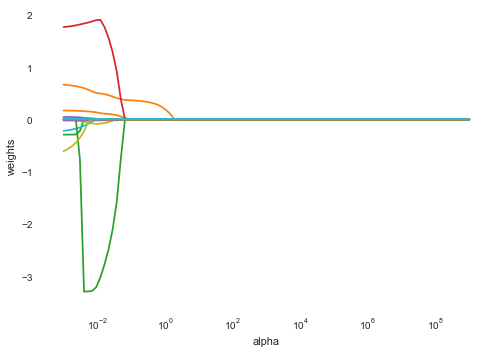

In [12]:
X = DatasetIIPandP.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetIIPandP["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Longitude", "Best12 Mo BOPD", "Repeater Ports", "Township", "Best6 Mo BOPD", "Stages", "Section", "Best3 Mo BOPD", "SPACING_CAPPED", "Sleeves", "Best1 Mo BOPD", "Lateral Length", "Fluid, bbls", "Total Prop, lbs"</pre>
<b>Features with weights that are greater than > 0.01:</b> 
    <pre>"Longitude", "Best12 Mo BOPD", "Repeater Ports", "Township", "Best6 Mo BOPD", "Stages", "Section", "Best3 Mo BOPD", "SPACING_CAPPED", "Sleeves"</pre>

<b>Longitude:</b>  The two positional features to indicate a location on a grid used are Longitude (East and West) and Township (North and South), this is opposed to Range and latitude. Regardless, East and West positioning seems to be a more important predictor of 12 month Cumulative Production.

<b>Best12 Mo BOPD:</b> Similar to the Iterative Imputation Dataset

<b>Repeater Ports:</b> The number of Repeater Ports in a well with the p and p completion type is an important feature for predicting the 12 month cumulative production. For more information, see the edgeworthbox notebook in the models folder.

<b>Township:</b> See Longitude

<b>Best6 Mo BOPD:</b> Best6 Mo BOPD has been pushed up in terms of importance

<b>Stages:</b> Since the number of stages did not have many imputed values, its importance in terms of rank did not change significantly, rather the other features importance in terms of rank changed around this. For more information see LASSO Regression analysis of the dataset with dropped entries.

<b>Best3 Mo BOPD:</b> Best3 Mo BOPD has been pushed up in terms of importance.

<b>SPACING_CAPPED:</b> Same reasoning as with the dataset with the dropped entries.

<b>Sleeves:</b> The number of Sleeves (more than the number of p and p) stages in a well with a p and p completion type is an important feature for predicting the 12 month cumulative production. For more information, see the edgeworthbox notebook in the models folder.

### Other

Train score: 0.9707992200442952
Test score: 0.9833797406488702
Number of coefficients used: 12
Root mean squared error: 4.8063487318190825
[-3.99867575e-04  3.24942393e-02  1.24831684e-02  0.00000000e+00
 -3.78034705e-02  2.04921063e-07 -0.00000000e+00  2.03161212e-03
  0.00000000e+00  0.00000000e+00  1.82445574e-01  1.50564818e-01
  0.00000000e+00 -1.29433249e+00  6.02811586e-03  0.00000000e+00
 -3.57072794e-02 -6.25351146e-03 -0.00000000e+00  0.00000000e+00]


Lateral Length    -3.998676e-04
Stages             3.249424e-02
Township           1.248317e-02
Range              0.000000e+00
Section           -3.780347e-02
Total Prop, lbs    2.049211e-07
Fluid, bbls       -0.000000e+00
Best1 Mo BOPD      2.031612e-03
Best3 Mo BOPD      0.000000e+00
Best6 Mo BOPD      0.000000e+00
Best9 Mo BOPD      1.824456e-01
Best12 Mo BOPD     1.505648e-01
Latitude           0.000000e+00
Longitude         -1.294332e+00
SPACING_CAPPED     6.028116e-03
Sleeves            0.000000e+00
P&P               -3.570728e-02
Frac Ports        -6.253511e-03
Repeater Ports    -0.000000e+00
CT                 0.000000e+00
dtype: float64

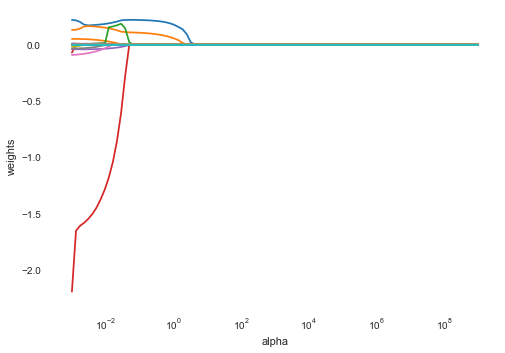

In [13]:
X = DatasetIIother.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetIIother["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis
<b>Features Selected (sorted):</b>
    <pre>"Longitude", "Best9 Mo BOPD", "Best12 Mo BOPD", "Section", "PandP", "Stages", "Township", "Frac Ports", "SPACING_CAPPED", "Best1 Mo BOPD", "Lateral Length", "Total Prop, lbs"</pre>
<b>Features with weights that are greater than > 0.01:</b> 
    <pre>"Longitude", "Best9 Mo BOPD", "Best12 Mo BOPD", "Section", "PandP", "Stages", Township"</pre>

<b>Longitude:</b>  The two positional features to indicate a location on a grid used are Longitude (East and West) and Township (North and South), this is opposed to Range and latitude. Regardless, East and West positioning seems to be a more important predictor of 12 month Cumulative Production.

<b>Best9 Mo BOPD:</b> In the Dataset with completiontypes other than p and p, and Sleeves, the Best9 Mo BOPD is more important than the Best12 Mo BOPD. However, similar to the other multivariate imputation techniques, the Best12 Mo BOPD is similarly important to bump up accuracy in predicting 12 month cumulative production and lower error.

<b>Best12 Mo BOPD:</b> See Best9 Mo BOPD

<b>PandP:</b> The number of P and P ports is an important factor in predicting 12 month cumulative production. For more information, see the edgeworthbox notebook in the models folder.

<b>Stages:</b> Since the number of stages did not have many imputed values, its importance in terms of rank did not change significantly, rather the other features importance in terms of rank changed around this. For more information see LASSO Regression analysis of the dataset with dropped entries.

<b>Township</b> See Longitude

<b>Other:</b> The number of stages could be a better predictor in 12 month cumulative production than lateral length, fluid, bbls, and total proppant.

In [29]:

features = DatasetIIandCI.copy()
features = features.drop(["Year Drilled", "Unnamed: 0"], axis = 1)
features["Sleeves"] = OriginalDatasetwTypes["Sleeves"]
features["P&P"] = OriginalDatasetwTypes["P&P"]
features["Frac Ports"] = OriginalDatasetwTypes["Frac Ports"]
features["Repeater Ports"] = OriginalDatasetwTypes["Repeater Ports"]
features["CT"] = OriginalDatasetwTypes["CT"]
features = features.fillna(0)
features = pd.get_dummies(features)
labels = np.array(features["12 month Cum Prod"])
features = features.drop(columns = ["12 month Cum Prod"])
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 23)




In [30]:

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state = 23)
rf.fit(train_features, train_labels)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=23, verbose=0, warm_start=False)

In [31]:

predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print("Mean Absolute Error:", round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 5.7 degrees.


In [32]:

mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print("Accuracy:", round(accuracy, 2), "%.")


Accuracy: 93.03 %.


In [18]:
"""
from sklearn.tree import export_graphviz
import pydot
tree = rf.estimators_[5]
export_graphviz(tree, out_file = "tree.dot",
               feature_names = feature_list, rounded = True,
               precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
"""

'\nfrom sklearn.tree import export_graphviz\nimport pydot\ntree = rf.estimators_[5]\nexport_graphviz(tree, out_file = "tree.dot",\n               feature_names = feature_list, rounded = True,\n               precision = 1)\n(graph, ) = pydot.graph_from_dot_file(\'tree.dot\')\ngraph.write_png(\'tree.png\')\n'

In [19]:
"""
rf_small = RandomForestRegressor(n_estimators = 10,
                                max_depth = 3)
rf_small.fit(train_features, train_labels)
tree_small = rf_small.estimators_[5]
export_graphviz(tree_small, out_file = 'small_tree.dot',
               feature_names = feature_list,
               rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')
"""

"\nrf_small = RandomForestRegressor(n_estimators = 10,\n                                max_depth = 3)\nrf_small.fit(train_features, train_labels)\ntree_small = rf_small.estimators_[5]\nexport_graphviz(tree_small, out_file = 'small_tree.dot',\n               feature_names = feature_list,\n               rounded = True, precision = 1)\n(graph, ) = pydot.graph_from_dot_file('small_tree.dot')\ngraph.write_png('small_tree.png')\n"

In [33]:

importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: Best12 Mo BOPD       Importance: 0.85
Variable: Best9 Mo BOPD        Importance: 0.05
Variable: Fluid, bbls          Importance: 0.02
Variable: Best1 Mo BOPD        Importance: 0.02
Variable: Stages               Importance: 0.01
Variable: Total Prop, lbs      Importance: 0.01
Variable: Best3 Mo BOPD        Importance: 0.01
Variable: Best6 Mo BOPD        Importance: 0.01
Variable: Lateral Length       Importance: 0.0
Variable: Township             Importance: 0.0
Variable: Range                Importance: 0.0
Variable: Section              Importance: 0.0
Variable: Latitude             Importance: 0.0
Variable: Longitude            Importance: 0.0
Variable: SPACING_CAPPED       Importance: 0.0
Variable: Sleeves              Importance: 0.0
Variable: P&P                  Importance: 0.0
Variable: Frac Ports           Importance: 0.0
Variable: Repeater Ports       Importance: 0.0
Variable: CT                   Importance: 0.0
Variable: Operator_Operator 1  Importance: 0.0
Varia

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Analysis
After applying a Random Forest Regressor through the Dataset with the Iterative Imputation and Conditional Imputation, The variables that explain the variance of the 12 month Cumulative production are Best12 Mo BOPD, Best9 Mo BOPD, followed by the best oil production rates per months. This is more general.